# AMO plot
This notebook is for plotting:

- **Supplementary Figure 10**: Correlation between the mean AMV phase and energy production
- **Figure 8**: Correlation coefficients between the 10-year mean AMV phase and the 10-year total cumulative anomalies 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import glob
import seaborn as sns
import scipy 
import pandas as pd

# Load the anomaly dataset
def compute_lat_weights(data):
    """Compute latitude weights (cosine of latitude) for area weighting."""
    weights = np.cos(np.deg2rad(data['lat']))
    weights.name = "weights"
    return weights

def preprocess_anomalies(data):
    """Calculate monthly climatology and anomalies (for SST or PSL)."""
    monthly_climatology = data.groupby('time.month').mean(dim='time')
    anomaly = data.groupby('time.month') - monthly_climatology
    return anomaly

def compute_global_mean(data_anomaly, weights):
    """Calculate the global mean anomaly using weights."""
    data_anomaly_weighted = data_anomaly.weighted(weights)
    global_mean = data_anomaly_weighted.mean(dim=['lat', 'lon'])
    return global_mean

def remove_global_mean(data_anomaly, global_mean):
    """Remove the global mean anomaly."""
    return data_anomaly - global_mean

def load_data(file_paths):
    """Load the ensemble of SST or PSL files."""
    ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='time')
    return ds

def restructure_timeseries(ds, section_length=120, dim='time', new_dim='runs'):
    """
    Restructure a dataset by cutting the time series into sections of fixed length and appending over a new dimension.
    """
    # Get the total length of the dimension
    total_length = len(ds[dim])
    
    # Create a list of slices to cut the time dimension into sections of section_length
    slicelist = [range(i, i + section_length) for i in range(0, total_length, section_length)]
    
    # Restructure the dataset by concatenating slices over the new dimension
    ds_restructured = xr.concat([ds.isel({dim: sl}) for sl in slicelist], dim=new_dim)
    
    return ds_restructured


def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]


def compute_summed_productions(ds):
    """
    Add summed energy production variables to the dataset.
    """
    ds['wind'] = ds['wind_onshore'] + ds['wind_offshore']
    ds['hydro'] = ds['ror'] + ds['Eout']
    ds['pv'] = ds['pv_util']
    return ds


def make_ds_anom(ds, timestep):
    groups = ds.stack(z=['runs', 'time']).groupby(timestep)
    return (groups-groups.mean()).unstack()



# Function to group by year, sum, and compute the mean over 'runs' and 'year'
def compute_decadal_mean(ds):
    # Group by year and sum the values for each year
    decadal_values = ds.sum(dim='time')
    return decadal_values.mean(dim='runs')


# Function to normalize the anomaly dataset over the decadal means
def normalize_dataset(ds_anom, decadal_mean):
    return ds_anom / decadal_mean


# Function to compute the cumulative sum and select the last time step (end of decade)
def compute_end_of_decade_cumsum(normalized_ds):
    # Compute the cumulative sum over the 'time' dimension
    cumsum_df = normalized_ds.cumsum(dim='time')
    
    # Select the last time step in the cumulative sum (end of the decade)
    end_of_decade_df = cumsum_df.isel(time=-1)
    
    # Select only the relevant columns
    selected_columns_df = end_of_decade_df[['pv', 'wind', 'hydro', 'demand', 'residual']]
    
    # Convert the result to a pandas DataFrame
    return selected_columns_df


# Main function that combines the steps
def process_end_of_decade(ds_anom, ds_regions):
    # Step 1: Compute decadal mean
    decadal_values_pd = compute_decadal_mean(ds_regions)
    
    # Step 2: Normalize the dataset over yearly means
    normalized_pd = normalize_dataset(ds_anom, decadal_values_pd)
    
    # Step 3: Compute the cumulative sum and select the last time step (end of the decade)
    normalized_df_end_of_decade = compute_end_of_decade_cumsum(normalized_pd)
    
    return normalized_df_end_of_decade


def load_and_process_energy_data2(file_pattern, metrics,  timestep='time.dayofyear', ratio=True):
    """
    Load regional energy production data, compute summed productions, calculate anomalies,
    and process data for the end of the decade.
    """
    # Load regional energy production data
    region_files = glob.glob(file_pattern)
    ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
    data = ds_regions.compute()
    
    # Compute summed productions
    data = compute_summed_productions(data)
    data = data[metrics]

    # Calculate anomalies using the provided anomaly function
    data_anom = make_ds_anom(data, timestep)

    data_anom_norm = process_end_of_decade(data_anom, data)

    return data_anom_norm.fillna(0)


In [2]:
# Load the subset of data for EOF computation
all_file_paths = sorted(glob.glob("LENTIS/present/month/tos_m_latlon/*"))
ds_full = load_data(all_file_paths)
# Extract the 'tos' variable
data_full = ds_full['tos']
# Preprocess full data and remove global mean
weights_full = compute_lat_weights(data_full)
data_anomaly_full = preprocess_anomalies(data_full)
global_mean_full = compute_global_mean(data_anomaly_full, weights_full)

# Define AMO region (Atlantic: 0° to 60°N, 285° to 352.5°E)
region_lon_range = (285, 352.5)
region_lat_range = (0,60)
data_anomaly_no_global_mean_full = remove_global_mean(
    data_anomaly_full.sel(lat=slice(*region_lat_range), lon=slice(*region_lon_range)),
    global_mean_full)

# data_anomaly_no_global_mean_full = data_anomaly_no_global_mean_full.compute()
# 
# Compute AMO index as weighted mean
amo_mean = data_anomaly_no_global_mean_full.weighted(weights_full.sel(lat=slice(*region_lat_range))).mean(dim=['lat', 'lon'])

amo_mean = restructure_timeseries(amo_mean)
runs = [f[-18:-14] for f in all_file_paths]
amo_mean['runs'] = runs
amo_results = amo_mean.mean(dim='time').compute()

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## correlate to energy vars

In [3]:
df = amo_results.to_dataframe().rename({'tos': 'amo_means'}, axis=1)
# ---------------------------
# Bootstrapping
# ---------------------------
runs_per_parent = split_into_chunks(df.index.values, 10)
dfamo_means = pd.concat([df.loc[runs, :].mean() for runs in runs_per_parent], axis=1)
# dfamo_means.columns = list(df.index)
regions = ["Nordic", "British Isles", "North Western", 
        "Central", "Iberia", "Baltic", "Eastern"]
# Define the data (this comes from 05_decadal_variability notebook)
data = {
    "Region": [
        "Nordic", "British Isles", "North Western", 
        "Central", "Iberia", "Baltic", "Eastern"
    ],
    "pv": [1, 0, 1, 1, 1, 1, 1],
    "wind": [1, 1, 1, 1, 1, 1, 1],
    "hydro": [1, 1, 0, 0, 0, 0, 1],
    "demand": [1, 1, 1, 1, 1, 1, 1],
    "residual": [1, 1, 0, 1, 0, 0, 0]
}

# Create the pandas DataFrame
significance_pd = pd.DataFrame(data)
significance_pd  = significance_pd .set_index('Region')


In [4]:
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']

# Example usage with compute_anom_ratio
anom_m_total_present = load_and_process_energy_data2(
    '*_PD.nc',
    metrics,
     ratio=True
)

# Example usage with compute_anom_ratio
anom_m_total_future = load_and_process_energy_data2(
    '*_PD.nc', 
    metrics,
     ratio=True
)

e_end_of_runs_pd = {}
for region in regions:
    ds_region = anom_m_total_present.sel(region=region)
    runs_per_parent = split_into_chunks(ds_region.runs.values, 10)
    e_end_of_runs_pd[region] = pd.concat([ds_region.sel(runs=runs).to_dataframe().mean() for runs in runs_per_parent], axis=1)
    
e_end_of_runs_fu = {}
for region in regions:

    ds_region = anom_m_total_future.sel(region=region)
    runs_per_parent = split_into_chunks(ds_region.runs.values, 10)
    e_end_of_runs_fu[region] = pd.concat([ds_region.sel(runs=runs).to_dataframe().mean() for runs in runs_per_parent], axis=1)

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


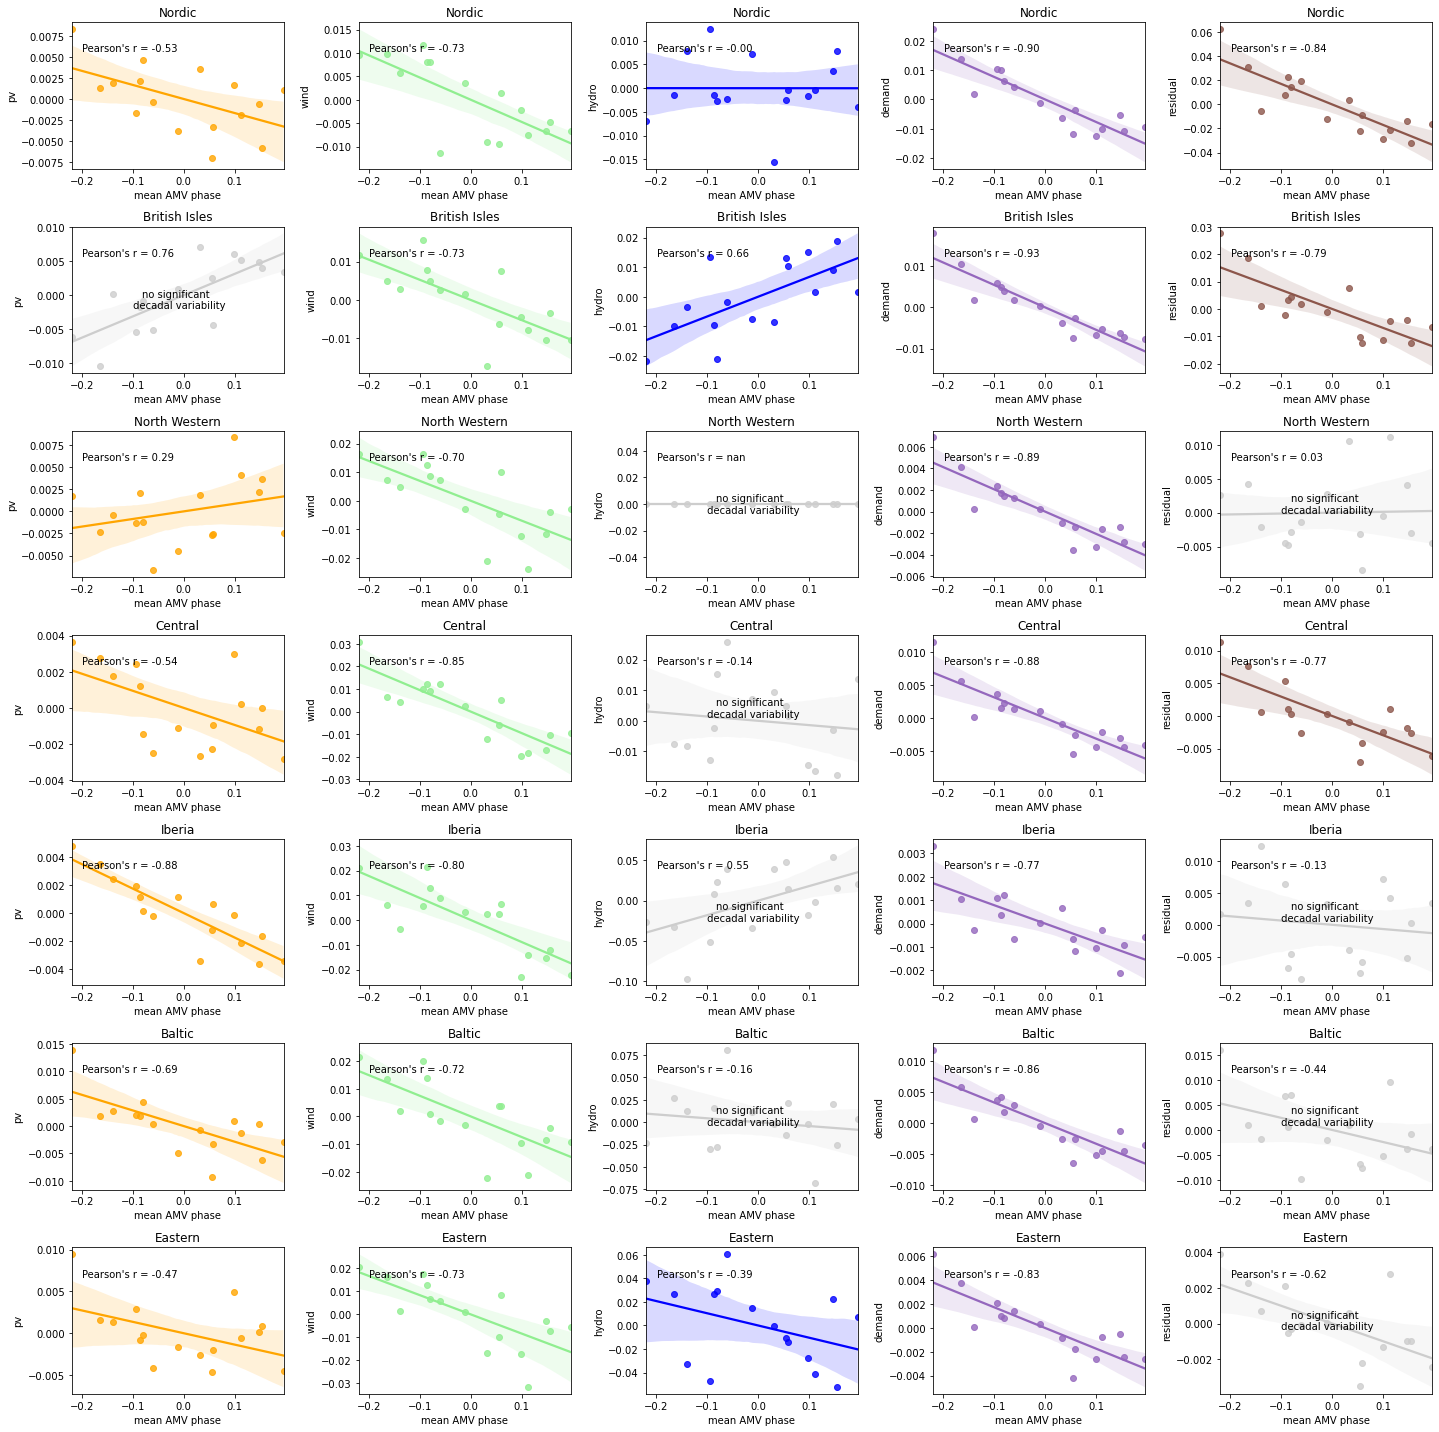

In [5]:
# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']

colors_dict = dict(zip(metrics, colors))

scenario = 'pd'

fig, axs = plt.subplots(7, 5, figsize=(20, 20))

for i,region in enumerate(regions):
    energy_end_of_runs = e_end_of_runs_pd[region] #anom_m_total_present.sel(region=region).to_dataframe().reset_index()[metrics].T
    for j, var in enumerate(metrics):
        test = dfamo_means.T
        test[var] = energy_end_of_runs.T[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])

        axs[i,j].set_title(region)
        
        test = test.rename({'amo_means': 'mean AMV phase'}, axis=1)

        if significance_pd.loc[region, var] == 1:
            sns.regplot(x='mean AMV phase', y=var, data=test, color=colors_dict[var], ax=axs[i,j])  
            axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)

        elif significance_pd.loc[region, var] == 0:
            sns.regplot(x='mean AMV phase', y=var, data=test, color="#CDCDCD", ax=axs[i,j])
            axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)
            # Build a rectangle in axes coords
            left, width = .25, .5
            bottom, height = .25, .5
            right = left + width
            top = bottom + height

            axs[i,j].text(0.5 * (left + right), 0.5 * (bottom + top), "no significant \n decadal variability",
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[i,j].transAxes)
            axs[i,j].set_ylabel(var)

fig.tight_layout()

plt.savefig("pd_pearsoncorr_AMO_parent_variancev2.jpg")
plt.show()

In [6]:

# Initialize dataframe to store correlation coefficients
correlation_data = pd.DataFrame(index=regions, columns=metrics)

# Calculate correlations
for region in regions:
    energy_end_of_runs = e_end_of_runs_pd[region]
    
    for var in metrics:
        test = dfamo_means.T.copy()
        test[var] = energy_end_of_runs.T[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])
        
        # Store the correlation coefficient
        correlation_data.loc[region, var] = r

# Convert correlation data to float for heatmap compatibility
correlation_data_pd = correlation_data.astype(float)



/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


## Future

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.xarray import Eof
import glob

# Load the subset of data for EOF computation
all_file_paths = sorted(glob.glob("future/month/tos_m_latlon/*"))
ds_full = load_data(all_file_paths)
# Extract the 'tos' variable
data_full = ds_full['tos']
# Preprocess full data and remove global mean
weights_full = compute_lat_weights(data_full)
data_anomaly_full = preprocess_anomalies(data_full)
global_mean_full = compute_global_mean(data_anomaly_full, weights_full)

# Define AMO region (Atlantic: 0° to 60°N, 285° to 352.5°E)
region_lon_range = (285, 352.5)
region_lat_range = (0,60)
data_anomaly_no_global_mean_full = remove_global_mean(
    data_anomaly_full.sel(lat=slice(*region_lat_range), lon=slice(*region_lon_range)),
    global_mean_full)

# data_anomaly_no_global_mean_full = data_anomaly_no_global_mean_full.compute()
# 
# Compute AMO index as weighted mean
amo_mean_fu = data_anomaly_no_global_mean_full.weighted(weights_full.sel(lat=slice(*region_lat_range))).mean(dim=['lat', 'lon'])

amo_mean_fu = restructure_timeseries(amo_mean_fu)
runs = [f[-18:-14] for f in all_file_paths]
amo_mean_fu['runs'] = runs

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


In [8]:
amo_results_fu = amo_mean_fu.mean(dim='time').compute()

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [9]:

# ---------------------------
# Bootstrapping
# ---------------------------
df_fu = amo_results_fu.to_dataframe().rename({'tos': 'amo_means'}, axis=1)
runs_per_parent = split_into_chunks(df_fu.index.values, 10)
dfamo_means_fu = pd.concat([df_fu.loc[runs, :].mean() for runs in runs_per_parent], axis=1)
# dfamo_means.columns = list(df.index)
regions = ["Nordic", "British Isles", "North Western", 
        "Central", "Iberia", "Baltic", "Eastern"]
# Define the data
data = {
    "Region": [
        "Nordic", "British Isles", "North Western", 
        "Central", "Iberia", "Baltic", "Eastern"
    ],
    "pv": [0, 0, 0, 0, 1, 0, 0],
    "wind": [1, 0, 0, 0, 0, 0, 0],
    "hydro": [1, 0, 1, 1, 0, 0, 1],
    "demand": [1, 1, 1, 1, 0, 1, 1],
    "residual": [1, 0, 0, 1, 0, 0, 1]
}
# Create the pandas DataFrame
significance_fu = pd.DataFrame(data)
significance_fu  = significance_fu.set_index('Region')

0.0


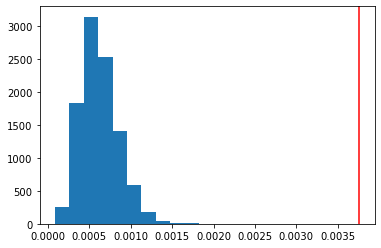

In [15]:
# boorstrapping
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import os

def split_into_chunks(lst, chunk_size):
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]


# ---------------------------
# Bootstrapping
# ---------------------------
df = amo_results_fu.to_dataframe().rename({'tos': 'amo_means'}, axis=1)
runs_per_parent = split_into_chunks(df.index.values, 10)

for j, var in enumerate(['amo_means']): 
    data = df[var].values

    subset_size = 10
    num_subsets = 16


    # Calculate means of each subset
    subset_means = np.array([df[var].loc[runs].mean() for runs in runs_per_parent])

    # Calculate observed variance of subset means
    observed_variance = np.var(subset_means, ddof=1)

#         print(f"Observed Variance of Subset Means for {var}: {observed_variance:.4f}")

    n_iterations = 10000  # Number of bootstrap samples
    bootstrap_variances = []

    for _ in range(n_iterations):
        # Resample data with replacement
        boot_data = resample(data, n_samples=160, replace=True)

        # Reshape into subsets
        boot_subset_data = boot_data.reshape(num_subsets, subset_size)

        # Calculate subset means
        boot_subset_means = boot_subset_data.mean(axis=1)

        # Calculate variance of subset means
        boot_var = np.var(boot_subset_means, ddof=1)
        bootstrap_variances.append(boot_var)

    bootstrap_variances = np.array(bootstrap_variances)

    # Calculate the proportion of bootstrap variances >= observed variance
    p_value = np.mean(bootstrap_variances >= observed_variance)
    
    print(p_value)
    plt.hist(bootstrap_variances)
    plt.axvline(observed_variance, color='red')

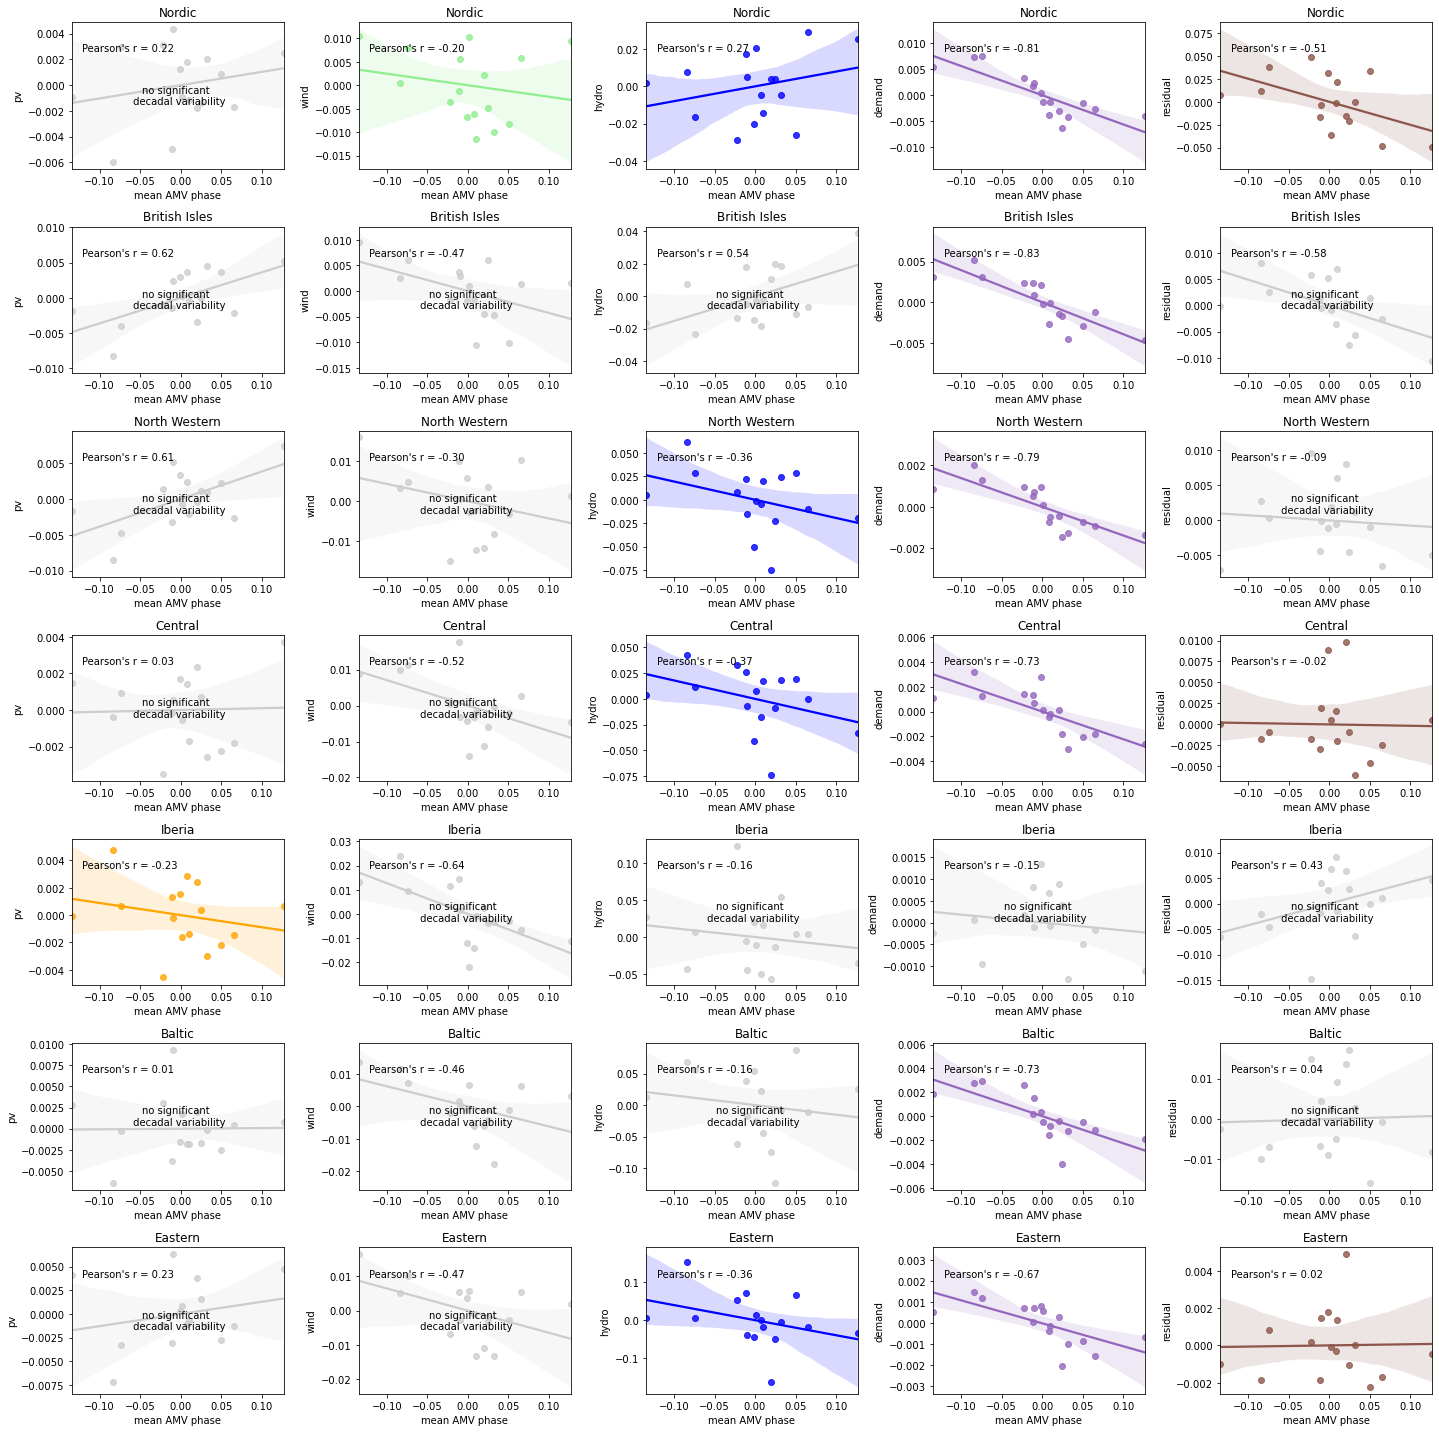

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

scenario = 'fu'

fig, axs = plt.subplots(7, 5, figsize=(20, 20))

for i,region in enumerate(regions):
    energy_end_of_runs = e_end_of_runs_fu[region] #anom_m_total_present.sel(region=region).to_dataframe().reset_index()[metrics].T
    for j, var in enumerate(metrics):
        test = dfamo_means_fu.T
        test[var] = energy_end_of_runs.T[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])

        test = test.rename({'amo_means': 'mean AMV phase'}, axis=1)
        axs[i,j].set_title(region)


        if significance_fu.loc[region, var] == 1:
            sns.regplot(x='mean AMV phase', y=var, data=test, color=colors_dict[var], ax=axs[i,j])  
            axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)

        elif significance_fu.loc[region, var] == 0:
            sns.regplot(x='mean AMV phase', y=var, data=test, color="#CDCDCD", ax=axs[i,j]) 
            axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)
            # Build a rectangle in axes coords
            left, width = .25, .5
            bottom, height = .25, .5
            right = left + width
            top = bottom + height

            axs[i,j].text(0.5 * (left + right), 0.5 * (bottom + top), "no significant \n decadal variability",
            horizontalalignment='center',
            verticalalignment='center',
            transform=axs[i,j].transAxes)
            axs[i,j].set_ylabel(var)

fig.tight_layout()

plt.savefig("fu_pearsoncorr_AMO_parent_variancev2.jpg")
plt.show()

In [17]:
# Variables and color settings
colors = ['orange', 'lightgreen', 'blue', '#9467bd', '#8c564b']
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))
scenario = 'fu'

# Initialize dataframe to store correlation coefficients
correlation_data = pd.DataFrame(index=regions, columns=metrics)

# Calculate correlations
for region in regions:
    energy_end_of_runs = e_end_of_runs_fu[region]
    
    for var in metrics:
        test = dfamo_means_fu.T.copy()
        test[var] = energy_end_of_runs.T[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])
        
        # Store the correlation coefficient
        correlation_data.loc[region, var] = r

# Convert correlation data to float for heatmap compatibility
correlation_data_fu = correlation_data.astype(float)

In [18]:
# Assuming correlation_date_pd and correlation_data_fu are your present and future dataframes
# Add a 'source' column to distinguish between present and future data
correlation_data_pd["scenario"] = "present"
correlation_data_fu["scenario"] = "future"

# Combine both datasets
combined_df = pd.concat([correlation_data_pd, correlation_data_fu])

# Reset the index for easier plotting
combined_df.reset_index(inplace=True)

# Melt the DataFrame for easier plotting with seaborn
melted_df = combined_df.melt(
    id_vars=["index", "scenario"],
    var_name="variable",
    value_name="correlation"
)

melted_df = melted_df.rename({'index': 'region'}, axis=1)
melted_df = melted_df.rename({'variable':'technology'}, axis=1)
correlation_df = melted_df
correlation_df['tech_scenario'] = correlation_df['technology'] + ' ' + correlation_df['scenario']

In [20]:
significance_pd

,pv,wind,hydro,demand,residual
Region,,,,,
Nordic,1,1,1,1,1
British Isles,0,1,1,1,1
North Western,1,1,0,1,0
Central,1,1,0,1,1
Iberia,1,1,0,1,0
Baltic,1,1,0,1,0
Eastern,1,1,1,1,0


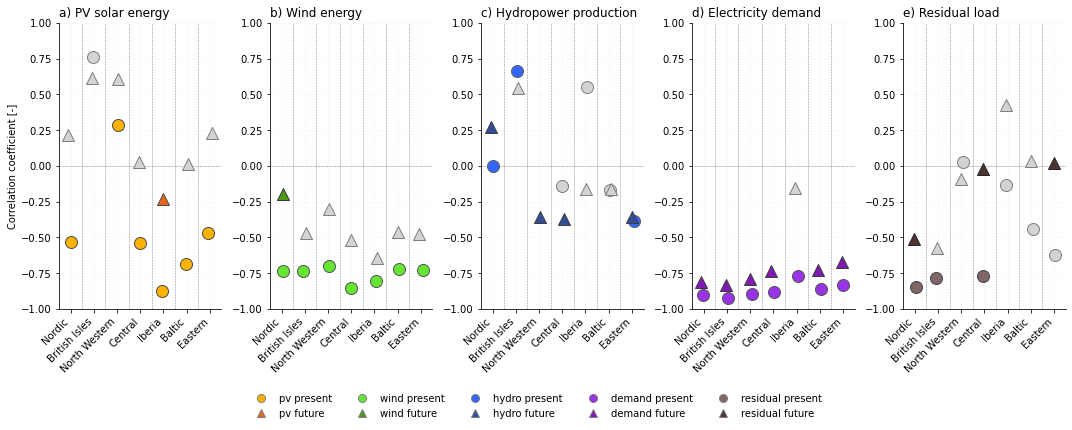

In [42]:
from matplotlib.lines import Line2D
significance_pd["scenario"] = "present"
significance_fu["scenario"] = "future"

# Combine both datasets
significance_df = pd.concat([significance_pd, significance_fu])

# Reset the index for easier plotting
significance_df.reset_index(inplace=True)

significance_df = significance_df.melt(
    id_vars=["Region", "scenario"],
    var_name="variable",
    value_name="correlation"
)
colors = [[(1.0, 0.7, 0.0),(0.9, 0.4, 0.1)], 
          [(0.4,0.9,0.2), (0.3, 0.6, 0.1)], 
          [(0.2,0.4,1), (0.2,0.3,0.6)],
          [(0.6, 0.2, 0.9),(0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))


# Define a custom palette for each variable
palette = {var: colors_dict[var][0] for var in metrics}

# Create a custom palette for significant values
palette = {f'{var} {scenario}': colors_dict[var][j] 
           for var in metrics for j, scenario in enumerate(['present', 'future'])}


# Define markers for scenarios
scenario_markers = {'present': 'o', 'future': '^'}  # 'o' for open circle, 's' for square

# Get unique technologies for iteration
technologies = significance_df['variable'].unique()

# Create a figure with subplots, one for each technology
fig, axes = plt.subplots(1, len(technologies), figsize=(len(technologies) * 3, 6), sharex=True)

# Initialize a dictionary for legend entries
legend_entries = {}

# Iterate over each technology and create a plot for it
for i, tech in enumerate(technologies):
    # Filter data for the current technology
    tech_data = correlation_df[correlation_df['technology'] == tech]
    sign_data = significance_df[significance_df['variable'] == tech].rename({'variable': 'technology', 'Region': 'region'}, axis=1)

    # Merge significance data to include p-values
    tech_data = tech_data.merge(sign_data, on=['region', 'scenario', 'technology'])

    # Create a dataset for non-significant values
    non_significant_data = tech_data.copy()
    non_significant_data.loc[tech_data['correlation_y'] > 0.95, 'correlation_x'] = np.nan

    # remove non significant values
    tech_data.loc[tech_data['correlation_y'] < 0.95, 'correlation_x'] = np.nan

    # Plot the strip plot for significant values with different hues for variables and markers for scenarios
    for scenario in ['present', 'future']:
        sns.stripplot(
            data=tech_data[tech_data['scenario'] == scenario],
            x='region', y='correlation_x', hue='tech_scenario', palette=palette,
            dodge=False, marker=scenario_markers[scenario], s=12, ax=axes[i], edgecolor="gray", linewidth=1
        )

    # Adjust grid lines for the x-axis
    x_ticks = axes[i].get_xticks()
    x_tick_labels = axes[i].get_xticklabels()
    x_grid_positions = x_ticks[:-1] + 0.5  # Shift the grid lines by 0.5 between ticks

    # Add custom grid lines between ticks
    for grid_pos in x_grid_positions:
        axes[i].axvline(grid_pos, color='grey', linestyle='--', linewidth=0.5)

    # Rotate x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    for scenario in ['present', 'future']:
        sns.stripplot(
            data=non_significant_data[non_significant_data['scenario'] == scenario],
            x='region', y='correlation_x', color='lightgrey',#hue='tech_scenario', palette=palette,
            dodge=False, marker=scenario_markers[scenario], s=12, ax=axes[i], edgecolor="gray", linewidth=1
        )
#     # Capture legend handles and labels for the current plot
#     handles, labels = axes[i].get_legend_handles_labels()
#     for handle, label in zip(handles, labels):
#         if label not in legend_entries:
#             legend_entries[label] = handle

    # Customize the subplot

    axes[i].axhline(0, color='grey', linestyle='--', linewidth=0.5)  # Horizontal line at zero
    axes[i].grid(True, linestyle='--', alpha=0.1)  # Add grid to each subplot
    axes[i].set_title(tech, fontsize=12)  # Add technology name as subplot title
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].set_ylabel('')

    # Remove the legend from individual subplots
    axes[i].legend_.remove()


    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_ylim([-1,1])


#     if axes[i] != axes[0]:
#         axes[i].set_yticklabels([])
axes[0].set_ylabel('Correlation coefficient [-]')
# # Add a common x-axis label
# fig.text(0.5, 0.04, 'Region', ha='center', fontsize=12)

# # Add a common y-axis label
# fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical', fontsize=12)


# # Add a common legend at the bottom of the figure
# fig.legend(
#     legend_entries.values(), legend_entries.keys(),
#     loc='upper center', ncol=5, frameon=False, fontsize=10,
#     bbox_to_anchor=(0.5, -0.05)
# )


# Define legend entries for each variable and scenario
legend_entries = []
for var in metrics:
    for scenario in ['present', 'future']:
        legend_entries.append(
            Line2D(
                [0], [0], color=palette[f'{var} {scenario}'], marker=scenario_markers[scenario],
                markersize=8, linestyle='None', label=f'{var} {scenario}', markeredgecolor="gray",markeredgewidth=1
            )
        )

# Add a common legend at the bottom of the figure
fig.legend(
    handles=legend_entries, loc='upper center', ncol=5, frameon=False, fontsize=10,
    bbox_to_anchor=(0.5, 0.05)
)

titels = ['PV solar energy', 'Wind energy', 'Hydropower production', 'Electricity demand', 'Residual load']

# Remove the titles
for i, (tit, ax) in enumerate(zip(titels, axes)):
    ax.set_title("")  # Clear the title for each subplot
    axes[i].set_title(f"{chr(97 + i)}) {tit}", fontsize=12, loc='left', x=0.0)

# Adjust layout to remove spacing between subplots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('AMO_correlation_per_technology_for_groups.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# individual runs

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


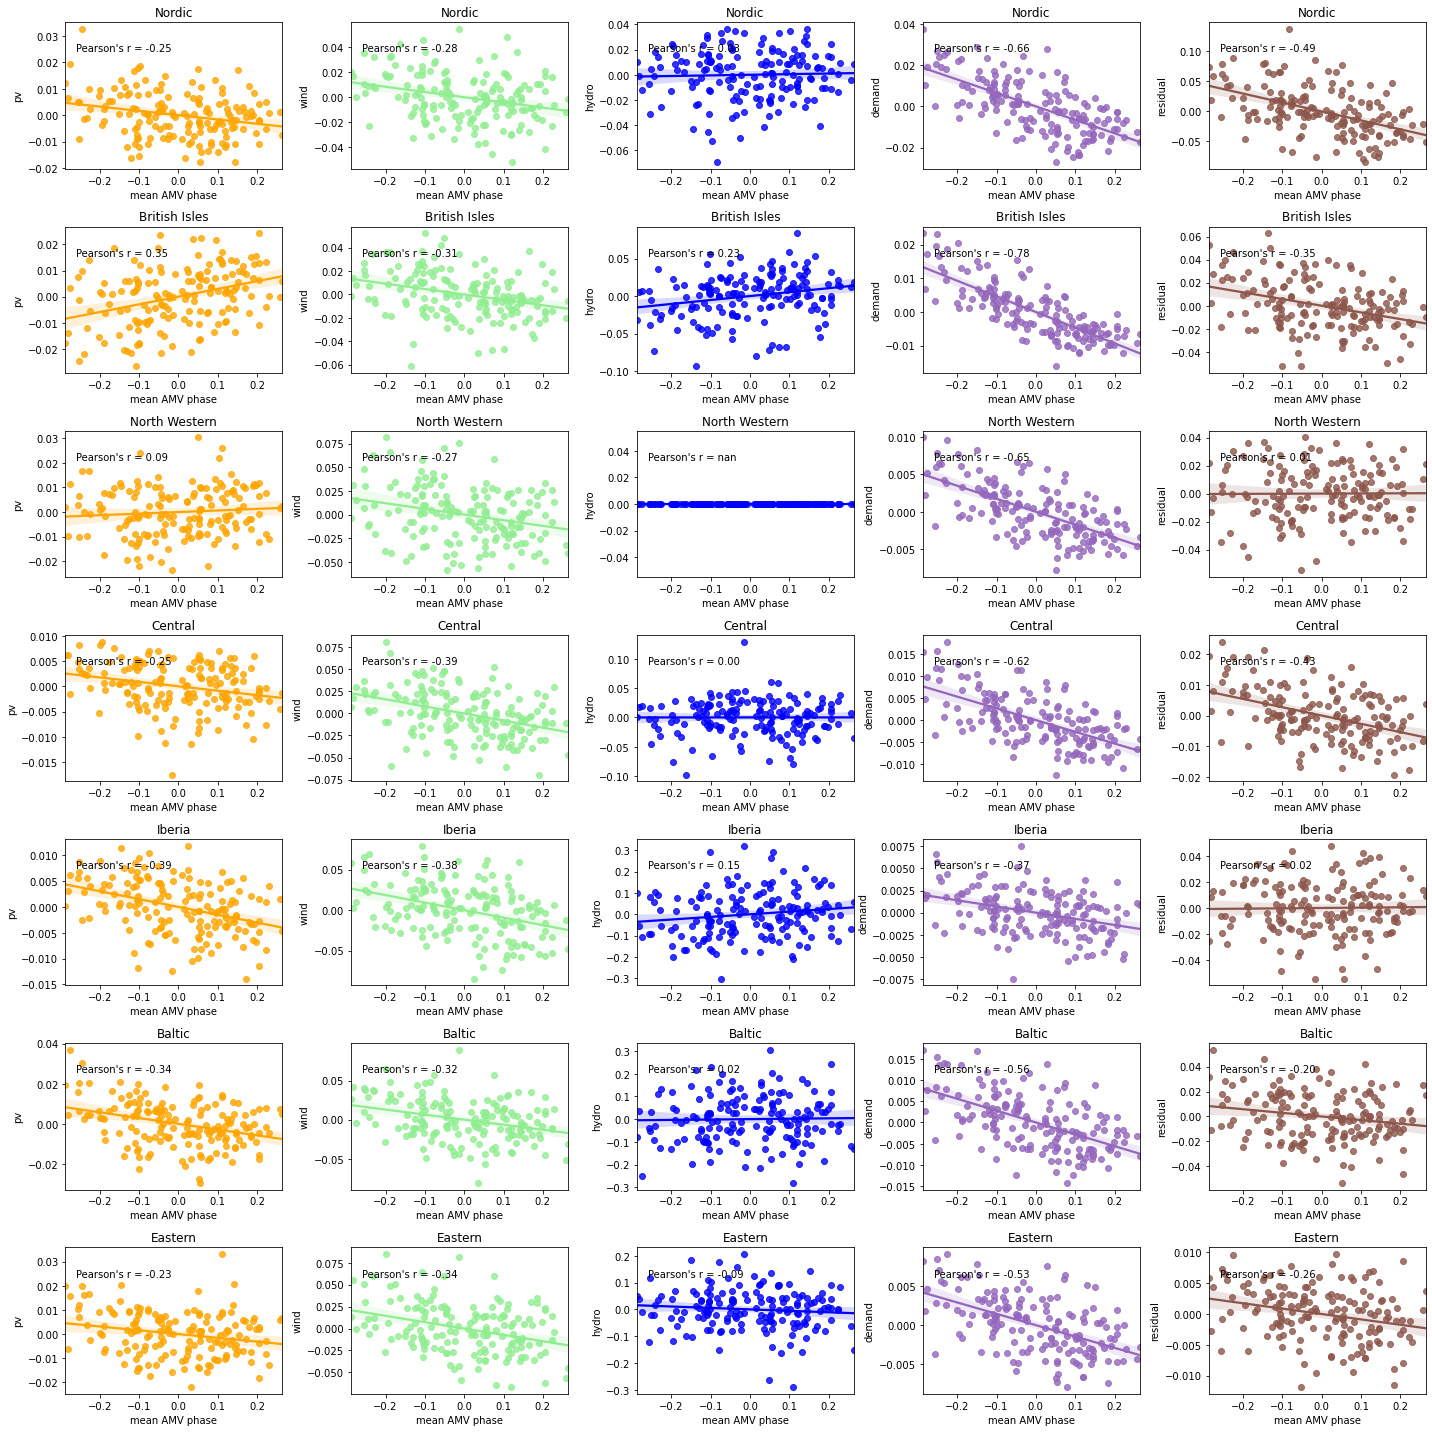

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

dfamo_pd = amo_results.to_dataframe().rename({'tos': 'amo_means'}, axis=1)


# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

scenario = 'pd'

fig, axs = plt.subplots(7, 5, figsize=(20, 20))

for i,region in enumerate(regions):
    energy_end_of_runs = anom_m_total_present.sel(region=region).to_dataframe()[metrics] #e_end_of_runs_pd[region] #anom_m_total_present.sel(region=region).to_dataframe().reset_index()[metrics].T
    for j, var in enumerate(metrics):
        test = dfamo_pd
        test[var] = energy_end_of_runs[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])

        axs[i,j].set_title(region)
        
        test = test.rename({'amo_means': 'mean AMV phase'}, axis=1)

        
        sns.regplot(x='mean AMV phase', y=var, data=test, color=colors_dict[var], ax=axs[i,j])  
        axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)

#         elif significance_pd.loc[region, var] == 0:
#             sns.regplot(x='mean AMV phase', y=var, data=test, color="#CDCDCD", ax=axs[i,j]) 
#             # Build a rectangle in axes coords
#             left, width = .25, .5
#             bottom, height = .25, .5
#             right = left + width
#             top = bottom + height

#             axs[i,j].text(0.5 * (left + right), 0.5 * (bottom + top), "no significant \n decadal variability",
#             horizontalalignment='center',
#             verticalalignment='center',
#             transform=axs[i,j].transAxes)
#             axs[i,j].set_ylabel(var)

fig.tight_layout()

plt.show()

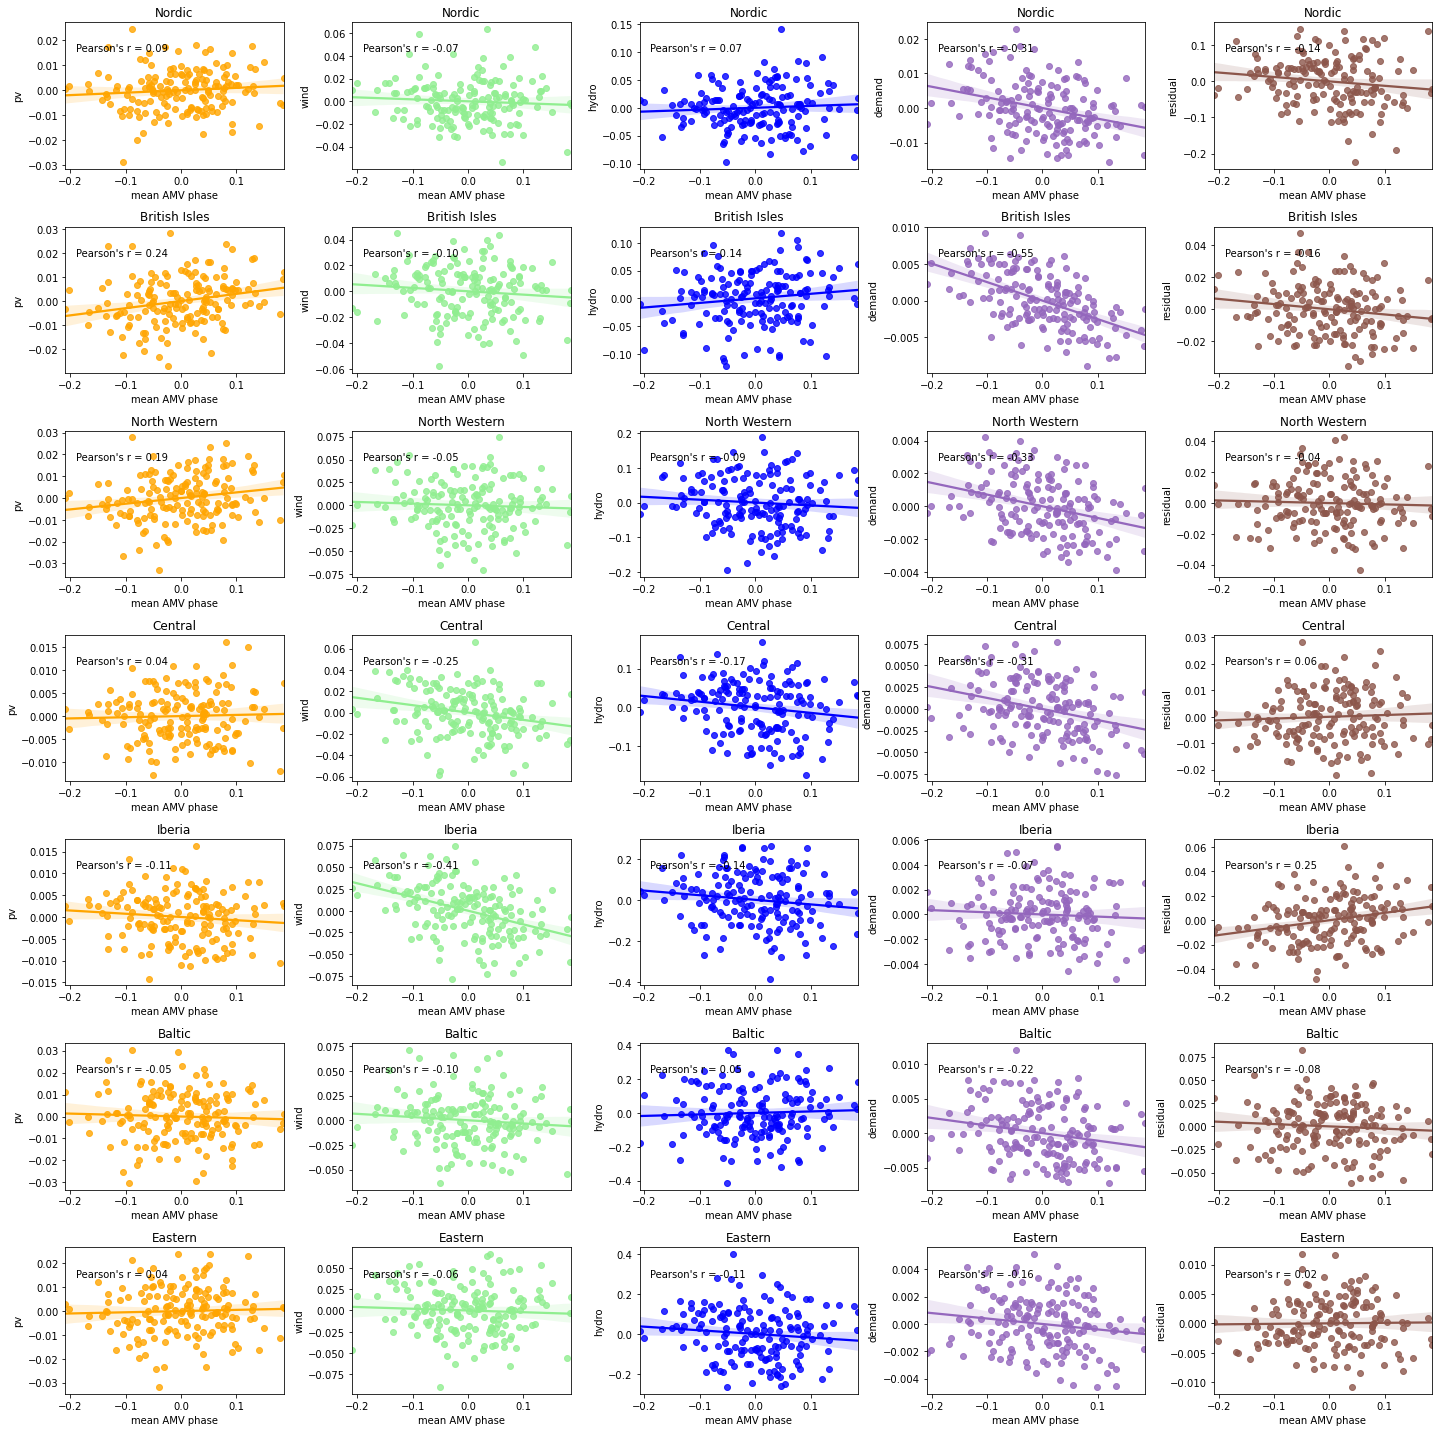

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

dfamo_fu = amo_results_fu.to_dataframe().rename({'tos': 'amo_means'}, axis=1)


# variables
colors = [ 'orange','lightgreen',  'blue',  '#9467bd', '#8c564b']
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))

scenario = 'pd'

fig, axs = plt.subplots(7, 5, figsize=(20, 20))

for i,region in enumerate(regions):
    energy_end_of_runs = anom_m_total_future.sel(region=region).to_dataframe()[metrics] #e_end_of_runs_pd[region] #anom_m_total_present.sel(region=region).to_dataframe().reset_index()[metrics].T
    for j, var in enumerate(metrics):
        test = dfamo_fu
        test[var] = energy_end_of_runs[var]
        r, p = scipy.stats.pearsonr(test['amo_means'], test[var])

        axs[i,j].set_title(region)
        
        test = test.rename({'amo_means': 'mean AMV phase'}, axis=1)

        
        sns.regplot(x='mean AMV phase', y=var, data=test, color=colors_dict[var], ax=axs[i,j])  
        axs[i,j].text(0.05, 0.8, "Pearson's r = {:.2f}".format(r), transform=axs[i,j].transAxes)

#         elif significance_pd.loc[region, var] == 0:
#             sns.regplot(x='mean AMV phase', y=var, data=test, color="#CDCDCD", ax=axs[i,j]) 
#             # Build a rectangle in axes coords
#             left, width = .25, .5
#             bottom, height = .25, .5
#             right = left + width
#             top = bottom + height

#             axs[i,j].text(0.5 * (left + right), 0.5 * (bottom + top), "no significant \n decadal variability",
#             horizontalalignment='center',
#             verticalalignment='center',
#             transform=axs[i,j].transAxes)
#             axs[i,j].set_ylabel(var)

fig.tight_layout()

plt.show()